In [108]:
import os
import json
import sklearn as sk
from sklearn.mixture import BayesianGaussianMixture
import numpy as np
import torch
import pandas as pd
import random
import matplotlib
import matplotlib.pyplot as plt

In [83]:
# set seeds
def set_seeds(seed = 42):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)

In [3]:
repo = os.path.dirname(os.path.abspath("__file__"))
data_file = os.path.join(repo, "sentence-pair-analysis")
preprocessed_file = os.path.join(data_file,"preprocessed-data.jsonl")
raw_file = os.path.join(data_file,"raw","batch1.csv")

print(f"File directory: {repo}\n")
print(f"Data directory: {data_file}\n")
print(f": {preprocessed_file}\n")
print(f"File directory: {raw_file}\n")

File directory: C:\Users\Willi\Documents\NYU\Research\NLU\crowdsourcing\pavlick-exp\NLI-variation-data

Data directory: C:\Users\Willi\Documents\NYU\Research\NLU\crowdsourcing\pavlick-exp\NLI-variation-data\sentence-pair-analysis

: C:\Users\Willi\Documents\NYU\Research\NLU\crowdsourcing\pavlick-exp\NLI-variation-data\sentence-pair-analysis\preprocessed-data.jsonl

File directory: C:\Users\Willi\Documents\NYU\Research\NLU\crowdsourcing\pavlick-exp\NLI-variation-data\sentence-pair-analysis\raw\batch1.csv



### Preprocessed Data Keys:
* __id__                     : id for the p/h pair, taken from original dataset when possible
* __premise__
* __hypothesis__
* __task__                   : name of dataset from which the pair was drawn
* __original-dataset-label__ : label given to p/h pair in the original dataset from which it was drawn
* __labels__                 : list of scores (-50 to 50) assigned by annotators on our annotation
* __normed-labels__          : list of z-normalized scores (-50 to 50) assigned by annotators on our annotation
* __num-NA__                 : number of annotators who indicated the p/h pair could not be judged for some reason

In [91]:
data = []

with open(preprocessed_file, "r") as f:
    for example in f:
        data.append(json.loads(example))

print(f"Number of observations is {len(data)}\n")        

#print example
print(f"Printing example.")
i = 0
print(f"Example input idx {i}:\n")
for key, item in data[i].items():
    print(f"{key}:{item}\n")

Number of observations is 496

Printing example.
Example input idx 0:

premise:What are they doing right that I did wrong? Maybe my mistake really was just a freak accident.

hypothesis:It is possible I was just a freak accident.

task:mnli

original-dataset-label:entailment

id:73712e

labels:[49.999903547520425, -49.99995111441214, -49.9999262535316, -50.00002216690942, -49.99997016358147, 2.9743475205649004e-05, -49.99991864902569, 50.000005487734626, 50.00007020674138, -37.999962284357004, 9.935426996016205e-05, -50.00001821982882, 23.000030071125416, 7.624772071405838e-06, 50.00005718658829, -50.000053039841006, -49.99992127683262, -28.99996378762132, -46.00002935867597, 3.0000817552118093, -49.999960995140164, -50.00005181855073, -28.000016451461523, 49.99999400284343, 2.7224880593486228e-05, 49.99998363923796, -50.00009330891493, 50.00009220806719, 23.999995182149863, -50.00009794576143, -34.000077596372115, -49.999965118989365, 50.00007936875679, -46.99994782046449, -49.9999426

In [101]:
def fit_example(
    example,
    n_hold_out = 10,
    n_splits = 10,
    n_generate = 100,
    verbose = False,
):
    
    # max number of points set to number of points in the training data
    results = []
    
    def fit_bgm(
        train,
        test,
        n_components,
        idx,
        verbose = False,
    ):
        temp_dist = {}
        bgm = BayesianGaussianMixture(n_components = n_components)
        temp_dist['train_labels'] = bgm.fit_predict(train)
        temp_dist['comp_weights'] = bgm.weights_
        temp_dist['comp_means'] = bgm.means_
        temp_dist['params'] = bgm.get_params()
        temp_dist['samples'] = bgm.sample(n_samples = n_generate)
        temp_dist['test_log_probs'] = bgm.score_samples(test)
        
        if verbose:
            k = "Multi"
            if n_components == 1:
                k = "Single"
                
            for key, item in temp_dist.items():
                print(f"{key} for {k}-GM split {idx}:\n {item}")
        
        return temp_dist
    
    for i in range(n_splits):
        example_array = np.array(example)
        n_samples = len(example_array)

        shuffled_indices = np.random.permutation(range(n_samples))
        train = example_array[shuffled_indices[:-n_hold_out]].reshape(-1,1)
        test = example_array[shuffled_indices[-n_hold_out:]].reshape(-1,1)

        assert len(train) >= 5, "Not consistent with paper!"

        multi_dist = fit_bgm(train, test, len(train), i, verbose)
        single_dist = fit_bgm(train, test, 1, i, verbose)
        
        results.append({
            "Multi" : multi_dist,
            "Single" : single_dist,
        })
    
    return results

def run_label_experiment(
    data,
    n_hold_out = 10,
    n_splits = 10,
    n_generate = 100,
    label_key = 'normed-labels',
    verbose = False,
):
    final_results = []
    for example in data:
        final_results.append(fit_example(example[label_key]))
    
    return final_results

In [96]:
set_seeds(seed=42)

debug_result = fit_example(data[0]['normed-labels'])

In [128]:
set_seeds(seed=42)

processed_data = run_label_experiment(data)

In [173]:
def plot_charts(
    data,
    log_l_on = True,
    comp_weight_on = True,
    multi_key = 'Multi',
    single_key = 'Single',
    lprob_key = 'test_log_probs',
    comp_weight_key = 'comp_weights',
    comp_weight_cutoff = 3,
):
    def plot_log_l(
        data,
        multi_key = 'Multi',
        single_key = 'Single',
        lprob_key = 'test_log_probs',
    ):
        # get data
        single = []
        multi = []
        
        for example in data:
            temp_single = []
            temp_multi = []
            
            for split in example:
                temp_single.append(np.average(split[single_key][lprob_key]))
                temp_multi.append(np.average(split[multi_key][lprob_key]))
            
            single.append(np.average(temp_single))
            multi.append(np.average(temp_multi))
                                
        # create figure
        fig, ax = plt.subplots()
        
        # format labels
        ax.set_yticks(np.arange(-2, 1, 0.5))
        ax.set_xticks(np.arange(-2, 1, 0.5))
        ax.set_ylim(-2, 0.5)
        ax.set_xlim(-2, 0.5)
        
        # set labels
        ax.set_xlabel('1 component')
        ax.set_ylabel('K components')
        
        # plot
        ax.scatter(single,multi,alpha=0.2)
        ax.plot([-2,0.5],[-2,0.5],'--',c='k')
        
        # Adjust layout
        fig.tight_layout()
        
        return fig
    
    def plot_comp_weights(
        data,
        multi_key = 'Multi',        
        comp_weight_key = 'comp_weights',
        comp_weight_cutoff = 3,
        colors = ['b','orange','g'],
        sortby = 'Component 1',
    ):
        
        assert len(colors)==comp_weight_cutoff, f"{comp_weight_cutoff} components but {len(colors)} colors"
        # get data
        comp_weights = {
            f'Component {i}' : []
            for i in range(comp_weight_cutoff)
        }
        
        for example in data:
            temp_comp_weights = {
                i : []
                for i in range(comp_weight_cutoff)
            }
            
            for split in example:
                for i in range(comp_weight_cutoff):
                    temp_comp_weights[i].append(split[multi_key][comp_weight_key][i])
            
            for i in range(comp_weight_cutoff):
                comp_weights[f'Component {i}'].append(np.average(temp_comp_weights[i]))

        comp_weights = pd.DataFrame(comp_weights).sort_values(by=sortby)
        comp_weights.reset_index(inplace=True, drop=True)
        
        # normalize weights
        comp_weights = comp_weights.div(comp_weights.sum(axis=1), axis=0)
        
        # create figure
        fig, ax = plt.subplots()
        
        # format labels
        ax.set_yticks(np.arange(0, 600, 100))
        ax.set_xticks(np.arange(0, 1.2, 0.2))
        ax.set_ylim(0, 500)
        ax.set_xlim(0, 1)
        
        # plot
        cum = pd.Series(0, index = range(comp_weights.shape[0]))
        for idx, col in enumerate(list(comp_weights.columns.values)):
            start = cum
            cum = cum + comp_weights[col]
            ax.barh(comp_weights.index.values,
                    comp_weights[col],
                    left = start,
                    color=colors[idx],
                    label=col,
                    height=1,
                   )
        
        # Adjust layout
        fig.tight_layout()
        
        return fig
    
    log_l_fig = None
    comp_weight_fig = None
    
    if log_l_on:
        log_l_fig = plot_log_l(
            data,
            multi_key = multi_key,
            single_key = single_key,
            lprob_key = lprob_key,
        )
    
    if comp_weight_on:
        plot_comp_weights(
            data,
            multi_key = multi_key,
            comp_weight_key = comp_weight_key,
            comp_weight_cutoff = comp_weight_cutoff,
            colors = ['b','orange','g'],
            sortby = 'Component 0',
        )
    
    return {
        'log prob'     : log_l_fig,
        'comp weights' : comp_weight_fig,
    }

{'log prob': <Figure size 432x288 with 1 Axes>, 'comp weights': None}

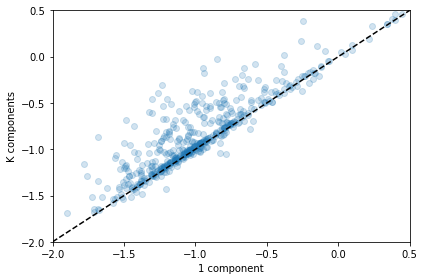

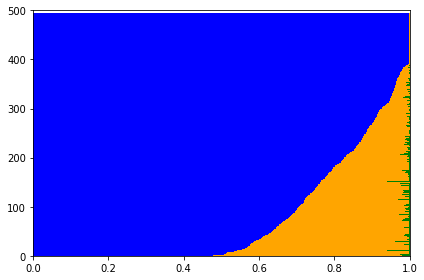

In [174]:
plot_charts(
    processed_data,
    log_l_on = True,
    comp_weight_on = True,
)

In [162]:
a = {k:[2,3]
    for k in range(2)}

b = pd.DataFrame(a)

print(b)
print(b.sum(axis=1))

c = b.div(b.sum(axis=1), axis = 0)

print(c)

d = pd.Series(0, index = range(c.shape[0]))

print(d)

d = d + c[0]

print(d)

   0  1
0  2  2
1  3  3
0    4
1    6
dtype: int64
     0    1
0  0.5  0.5
1  0.5  0.5
0    0
1    0
dtype: int64
0    0.5
1    0.5
dtype: float64


### Raw data dump from MT

In [9]:
rawdf = pd.read_csv(raw_file)

In [17]:
print(f"Size of raw data dump is {rawdf.shape}\n")

print(list(rawdf.columns.values))

Size of raw data dump is (120, 169)

['HITId', 'HITTypeId', 'Title', 'Description', 'Keywords', 'Reward', 'CreationTime', 'MaxAssignments', 'RequesterAnnotation', 'AssignmentDurationInSeconds', 'AutoApprovalDelayInSeconds', 'Expiration', 'NumberOfSimilarHITs', 'LifetimeInSeconds', 'AssignmentId', 'WorkerId', 'AssignmentStatus', 'AcceptTime', 'SubmitTime', 'AutoApprovalTime', 'ApprovalTime', 'RejectionTime', 'RequesterFeedback', 'WorkTimeInSeconds', 'LifetimeApprovalRate', 'Last30DaysApprovalRate', 'Last7DaysApprovalRate', 'Input.task_name_0', 'Input.pair_id_0', 'Input.label_0', 'Input.p_0', 'Input.h_0', 'Input.task_name_1', 'Input.pair_id_1', 'Input.label_1', 'Input.p_1', 'Input.h_1', 'Input.task_name_2', 'Input.pair_id_2', 'Input.label_2', 'Input.p_2', 'Input.h_2', 'Input.task_name_3', 'Input.pair_id_3', 'Input.label_3', 'Input.p_3', 'Input.h_3', 'Input.task_name_4', 'Input.pair_id_4', 'Input.label_4', 'Input.p_4', 'Input.h_4', 'Input.task_name_5', 'Input.pair_id_5', 'Input.label_5', 

In [45]:
print(f"{len(rawdf['WorkerId'].unique())}\n")

71



In [27]:
count_na = 0
count_rating = 0

for col_name in list(rawdf.columns.values):
    if 'Answer.na' in col_name:
        count_na += 1
    
    if 'Answer.rating' in col_name:
        count_rating += 1
        
print(f"Number of Answer.na: {count_na}")
print(f"Number of Answer.rating: {count_rating}")

Number of Answer.na: 20
Number of Answer.rating: 20


#### Reformat data into dictionary with batched HITs

In [43]:
newraw = {}
batch_n = 20
batch_keys_orig = [
    'HITId',
    'AssignmentId',
]

example_keys = [
    'Input.task_name',
    'Input.pair_id',
    'Input.label',
    'Input.p',
    'Input.h',
    'Answer.na',
    'Answer.rating',
]

for i, row in rawdf.iterrows():
    temp_batch = {}
    temp_tasks = {}
    
    for key in batch_keys_orig:
        temp_batch[key] = row[key]
    
    for idx in range(batch_n):
        temp_example = {}
        
        for key in example_keys:
            try:
                temp_example[key] = row[key+f'{idx}']
            except:
                temp_example[key] = row[key+f'_{idx}']
        
        temp_tasks[idx] = temp_example
    temp_batch['Tasks'] = temp_tasks
    
    worker_example = newraw.get(row['WorkerId'], False)
    if worker_example:
        worker_example['Batches'].append(temp_batch)
    else:
        newraw[row['WorkerId']] = {
            'WorkerId' : row['WorkerId'],
            'Batches'  : [temp_batch]
        }